In [1]:
import torch
from random import sample
import numpy as np
import os
import pandas as pd
import torch.nn as nn
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from torchvision.io import read_image
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms
from matplotlib import colors, pyplot as plt
%matplotlib inline
from PIL import Image


device = 'cuda' if torch.cuda.is_available() else 'cpu'   # Меняем наш механизм на работу от гпу
print(device)

cuda


In [2]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
100% 1.08G/1.08G [01:01<00:00, 22.1MB/s]
100% 1.08G/1.08G [01:01<00:00, 18.8MB/s]


In [3]:
!unzip /content/the-simpsons-characters-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1281.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1282.jpg  
  inflating: simpsons_dataset/simpsons_datas

In [4]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files, mode):
#         super().__init__()
        self.files = sorted(files)    # Сортируем изображения
        self.mode = mode    # Тип входных данных

        self.label_encoder = LabelEncoder()    # Нормализуем наши лейблы

        if self.mode != 'test':    # В случае, если мы работаем не с тестовыми данными, то сразу закинем ответы к 
            self.labels = [path.parent.name for path in self.files]    # тренировочным данным (имя персонажа содержится 
            self.label_encoder.fit(self.labels)    # в названии папки с фотографиями) и сортируем по итогу наши лейблы

    def __len__(self):
        return len(self.files)    # Количество файлов в папке
      
    def load_sample(self, file):
        image = Image.open(file)    # Открываем изображение
        image.load()    # Загружаем его
        return image
  
    def __getitem__(self, index):
        transformers = {self.mode: transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(224),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}    # Объединяем трансформации
        image = self.load_sample(self.files[index])    # Открываем изображение по индексу
        
        image = transformers[self.mode](image)    # Переходим к нашему изображению

        if self.mode == 'test':    # Если это тестовые данные, то возвращаем всё без лейблов
            return image
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])    # Оставляем лишь столбец с лейблами
            label = label_id.item()    # Вытаскиваем лейблы (item это метод словарей)
            return image, label


In [19]:
train_dir = Path('/content/simpsons_dataset')
test_dir = Path('/content/kaggle_simpson_testset')

buffer_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

buffer_labels = [path.parent.name for path in buffer_files]

train_files, val_files = train_test_split(buffer_files, test_size=0.3, stratify=buffer_labels)

annotations = pd.read_csv('/content/annotation.txt',header=None)
annotations.columns = ['images', 'x1','y1','x2','y2','character']
#annotations   

In [6]:
class Classifier(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()    # Обращаемся к отцовскому конструктору nn.Module
        self.encoder = torchvision.models.mobilenet_v2(pretrained = True).features    #  Обученная фигня
        self.linear_classifier = torch.nn.Linear(1280, num_classes)    # Отрезаем голову нашему отцовскому
                                                                      # классификатору и вставляем наши 42 класса
    def forward(self, sample):
        final_feature_map = self.encoder(sample)    # Все слои и прочая муть от мобайлнета (backbone тоже разрешён)
        pooled_features = nn.functional.adaptive_avg_pool2d(final_feature_map, (1, 1))    # Вытаскиваем признаки
        flatten_features = torch.flatten(pooled_features, 1)    # Делаем одноразмерный тэнзор
        logits = self.linear_classifier(flatten_features) # argmax(logits) = pred_class    Отрезаем голову
        return logits

In [7]:
val_dataset = SimpsonsDataset(val_files, mode='val')    # Обрабатываем валидационные данные
train_dataset = SimpsonsDataset(train_files, mode='train')    # Обрабатываем тренировочные данные

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)    # Загоняем наши входные данные на CPU
        labels = labels.to(device)    # Загоняем лэйблы на CPU
        optimizer.zero_grad()    # Обнуляем наши градиенты на бэкпропе, чтобы те никак не повлияли на значения новых градиентов

        outputs = model(inputs)    # Получаем выходные данные
        loss = criterion(outputs, labels)    # Высчитываем функцию потерь, зная выходные значения и реальные лейблы
        loss.backward()    # Вычисляем градиенты
        optimizer.step()    # Обновим наши параметры
        preds = torch.argmax(outputs, 1)    # Ищем индексы максимальных значений в  массиве
        running_loss += loss.item() * inputs.size(0)    # Складываем ошибки
        running_corrects += torch.sum(preds == labels.data)    # Находим количество верных предсказаний
        processed_data += inputs.size(0)    # Суммируем количество входных данных

    train_loss = running_loss / processed_data    # Подводим итоги в вычислениях функции потерь   
    train_acc = running_corrects.cpu().numpy() / processed_data    # Вычисляем accuracy
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # Подгружаем наши тренировачные 
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # и валидационные данные

    history = []    # Список для хранения результатов обучения
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:    # Используем tqdm для того чтобы выпендриться и вывести красивый
                                                            # результат обучения нашей модели
                                                            # Также здесь можно добавить схему изменения learning rate
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        criterion = nn.CrossEntropyLoss()    # Объявляем о функции потерь, которую будем использовать

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # Для красоты
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [17]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            # inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [10]:
n_classes = len(np.unique(buffer_labels))
model = Classifier(n_classes).to(device)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s]


Classifier(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e

In [11]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=32)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.964633611199116


epoch:  10%|█         | 1/10 [05:08<46:20, 308.91s/it]


Epoch 001 train_loss: 0.9646     val_loss 0.3725 train_acc 0.7741 val_acc 0.9111
loss 0.4251301671318379


epoch:  20%|██        | 2/10 [09:59<39:44, 298.11s/it]


Epoch 002 train_loss: 0.4251     val_loss 0.3037 train_acc 0.8900 val_acc 0.9200
loss 0.19133526421429997


epoch:  30%|███       | 3/10 [14:50<34:25, 295.05s/it]


Epoch 003 train_loss: 0.1913     val_loss 0.2127 train_acc 0.9510 val_acc 0.9496
loss 0.10385959706173421


epoch:  40%|████      | 4/10 [19:41<29:20, 293.34s/it]


Epoch 004 train_loss: 0.1039     val_loss 0.1860 train_acc 0.9737 val_acc 0.9577
loss 0.05943780961612797


epoch:  50%|█████     | 5/10 [24:35<24:27, 293.59s/it]


Epoch 005 train_loss: 0.0594     val_loss 0.1119 train_acc 0.9857 val_acc 0.9763
loss 0.027247534107657373


epoch:  60%|██████    | 6/10 [29:26<19:30, 292.51s/it]


Epoch 006 train_loss: 0.0272     val_loss 0.0926 train_acc 0.9946 val_acc 0.9799
loss 0.01265194817013307


epoch:  70%|███████   | 7/10 [34:16<14:35, 291.86s/it]


Epoch 007 train_loss: 0.0127     val_loss 0.0891 train_acc 0.9979 val_acc 0.9834
loss 0.005021608592365723


epoch:  80%|████████  | 8/10 [39:07<09:43, 291.67s/it]


Epoch 008 train_loss: 0.0050     val_loss 0.0782 train_acc 0.9995 val_acc 0.9846
loss 0.0027985862872379557


epoch:  90%|█████████ | 9/10 [44:00<04:51, 291.84s/it]


Epoch 009 train_loss: 0.0028     val_loss 0.0817 train_acc 0.9997 val_acc 0.9858
loss 0.0020514727387334216


epoch: 100%|██████████| 10/10 [48:50<00:00, 293.10s/it]


Epoch 010 train_loss: 0.0021     val_loss 0.0798 train_acc 0.9998 val_acc 0.9861


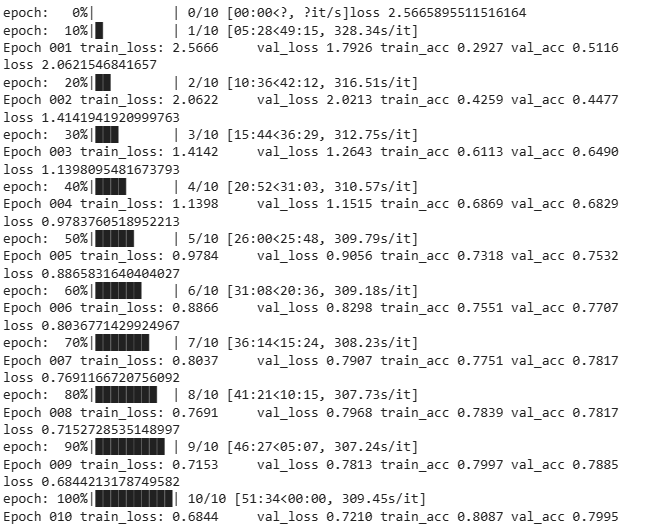

In [12]:
loss, acc, val_loss, val_acc = zip(*history)


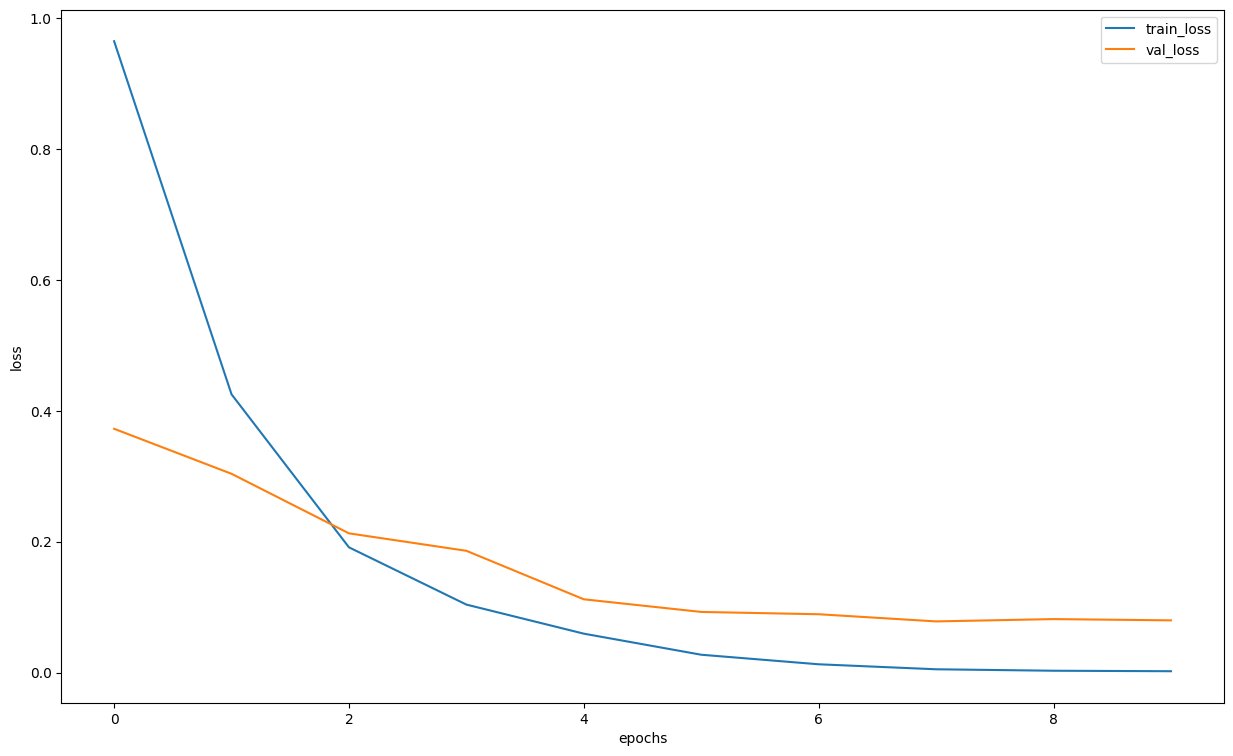

In [13]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [14]:
torch.save(model, 'net_1.pkl')